# Questions to Explore: 


Are popular products better than less popular ones (based on customer reviews)?<br><br>
What are the salient words and phrases used in the reviews of popular products?<br><br>
Do customer opinions change from early to late reviews?<br><br>
After the product is launched, what is the trend of positive and negative reviews over time? <br><br>

In [ ]:
# pip install nltk seaborn pandas numpi

In [1]:
# I didn't put any google trends data here since we are only exploring amazon reviews in this notebook.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
    
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline


def GetMergedAmazonDataFrames():
    files_to_use = [r'data\AirPods Pro.csv', r'data\Elite 75t.csv',r'data\Free.csv',
                   r'data\Galaxy Buds Plus.csv',r'data\M-200.csv',r'data\NC700.csv',
                   r'data\Soundcore Liberty 2 Pro.csv',r'data\Soundcore Liberty Air 2.csv',r'data\Soundcore Life Q20.csv',
                   r'data\WF-1000XM3.csv']
    amzn_df = pd.read_csv(files_to_use[0],  parse_dates=False)
    for file in files_to_use[1:]:
        df = pd.read_csv(file,  parse_dates=False)
#         amzn_df = pd.merge(amzn_df, df, how='outer',on='review_date')
        amzn_df = pd.concat([amzn_df,df],sort=False)
        
    amzn_df['review_date'] = pd.to_datetime(amzn_df['review_date'], format='%Y-%m-%d')
    amzn_df = amzn_df[['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text']]
    return amzn_df
    

import numpy as np

def Normalize(array):
    return array / np.linalg.norm(array, ord=1)
    
# Sav-golay filter for averaging.
def savGolay(array, window = 9, order =7):
    from scipy.ndimage import convolve1d
    from scipy.signal import savgol_coeffs, savgol_filter
    from scipy.signal._savitzky_golay import _polyder
    return savgol_filter(array, window, order)
   
# Simple Moving Average used in financial data.
def SMA(pandas_df_daily,columnName, dayWindowSize=20):
    daily_close_df = pandas_df_daily[columnName].copy()
    return daily_close_df.rolling(dayWindowSize).mean()

# weather_df['review_date'] = pd.to_datetime(weather_df['review_date'], format='%Y-%m-%d')
# googleTrends_df
amzn_df = GetMergedAmazonDataFrames()
print(amzn_df.columns)
print(amzn_df['ProductName'].unique())
amzn_df.head()

Index(['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
       'review_date', 'review_title', 'review_text'],
      dtype='object')
['AirPods Pro' 'Elite 75t' 'Free' 'Galaxy Buds Plus' 'M-200' 'NC700'
 'Soundcore Liberty 2 Pro' 'Soundcore Liberty Air 2' 'Soundcore Life Q20'
 'WF-1000XM3']


,Manufacturer,ProductName,review_rating,verified_purchase,review_date,review_title,review_text
0,Apple,AirPods Pro,5,0,2019-10-30,Airpods Pro deliver😎,This airpods pro do exactly what apple said th...
1,Apple,AirPods Pro,4,0,2019-10-30,List of Features/Changes compared to Airpods (v2),"Like iphone 11 Pro, Macbook Pro, Airpad Pro; t..."
2,Apple,AirPods Pro,3,0,2019-10-30,Cool but expensive,First review yeh heard about these excited but...
3,Apple,AirPods Pro,5,0,2019-10-30,Lit,They fire
4,Apple,AirPods Pro,5,1,2019-10-31,Saved my marriage,"With the new transparency mode, I can listen t..."


Text(0.5, 1.0, 'Distribution of reviews between purchases and not purchased')

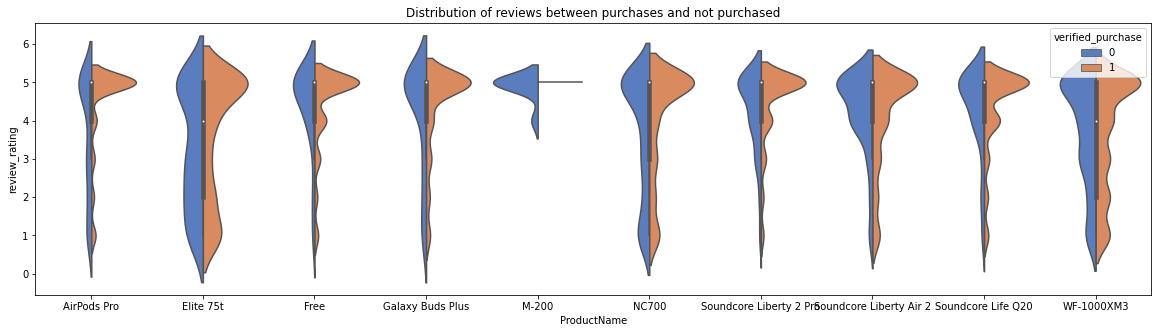

In [6]:

# Index(['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
#        'review_date', 'review_title', 'review_text'],
#       dtype='object')

plt.figure(figsize=(20,5))
sns.violinplot(x="ProductName", y="review_rating", hue="verified_purchase",
                    data=amzn_df, palette="muted", split=True).set_title('Distribution of reviews between purchases and not purchased')


Notice in the above chart verified and not purchased reviews are heavily skewed towards 5 star ratings. It seems that most reviews are either going to be 5 or 1 stars, but this tendency doesn't exist for all items. Why do some items show a bimodal distributions and others dont?

[4. 3. 2.]


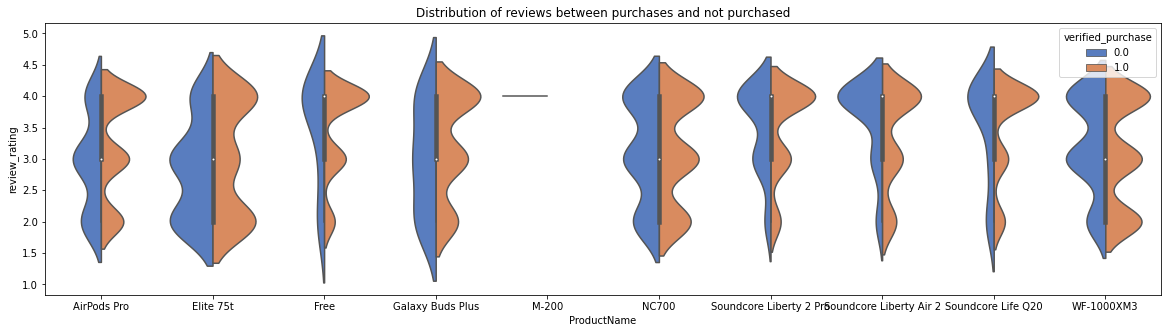

In [9]:
# Let's exclude the 5 and 1 star ratings and see what the violin plot looks like...

filtered_df  = amzn_df.where( (amzn_df['review_rating'] != 5) & (amzn_df['review_rating'] != 1)).dropna()
plt.figure(figsize=(20,5))
sns.violinplot(x="ProductName", y="review_rating", hue="verified_purchase",
                    data=filtered_df, palette="muted", split=True).set_title('Distribution of reviews between purchases and not purchased')

print(filtered_df['review_rating'].unique())

After removing the highest and lowest reviews we see a more evenly distributed set. Most products are evenly distributed... only a few products actually have a skewd distribution. Are the skewed distributions showing good products? To learn more I'll have to dive into the words used for the reviews.

['AirPods Pro' 'Elite 75t' 'Free' 'Galaxy Buds Plus' 'M-200' 'NC700'
 'Soundcore Liberty 2 Pro' 'Soundcore Liberty Air 2' 'Soundcore Life Q20'
 'WF-1000XM3']


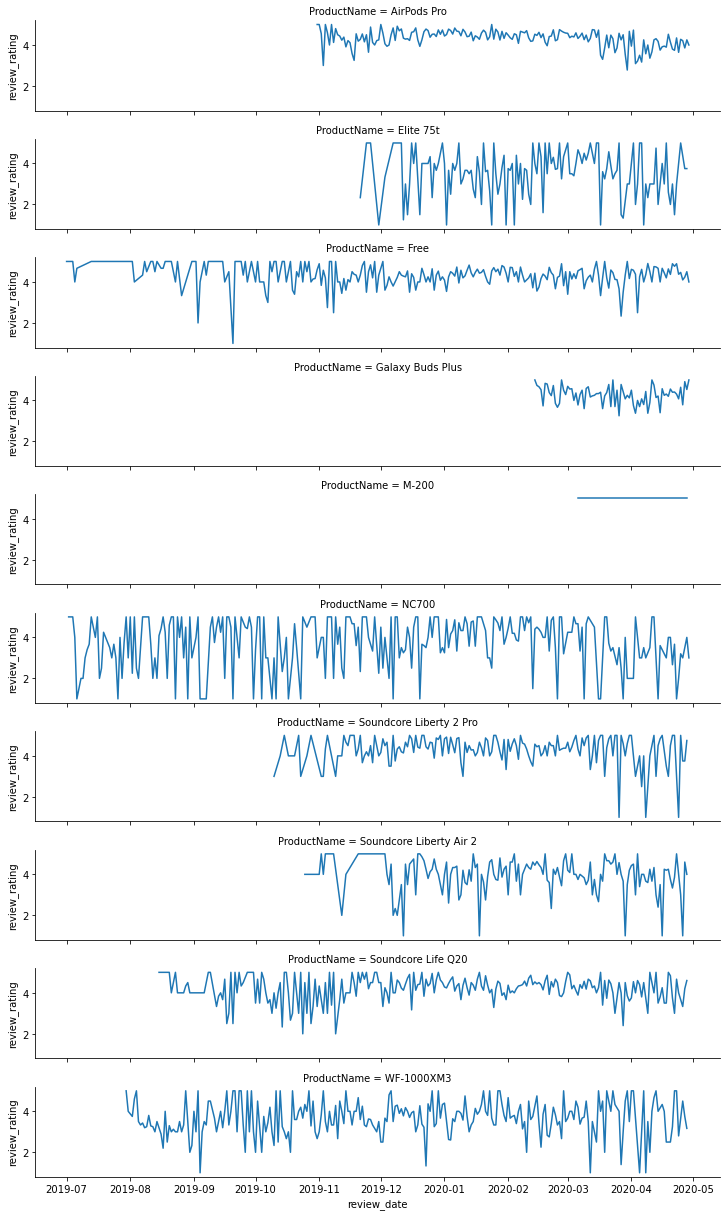

In [25]:
# ['Manufacturer', 'ProductName', 'review_rating', 'verified_purchase',
#        'review_date', 'review_title', 'review_text']
print(amzn_df['ProductName'].unique())

def FormatProductReviewRatingsAndDates(df, productName=None):
    if productName is not None:
        galaxyBuds_df = df.where(df['ProductName'].str.contains(productName)).dropna()
    else:
        galaxyBuds_df = df
    # Let's only look at verified purchases
    galaxyBuds_df = galaxyBuds_df.where(galaxyBuds_df['verified_purchase']== 1).dropna()
    galaxyBuds_df = galaxyBuds_df[['review_date', 'ProductName', 'review_rating']]
    galaxyBuds_df = galaxyBuds_df.groupby(['ProductName','review_date']).mean().reset_index()
#     galaxyBuds_df = galaxyBuds_df.set_index('review_date').resample('M').mean()
    return galaxyBuds_df

# average the reviews on time
# galaxyBuds_df = FormatProductReviewRatingsAndDates(amzn_df, 'Galaxy Buds Plus')

galaxyBuds_df = FormatProductReviewRatingsAndDates(amzn_df)

ordered_days = galaxyBuds_df.ProductName
g = sns.FacetGrid(galaxyBuds_df, row="ProductName", height=1.7, aspect=6,)

# g.fig.subplots_adjust(top=0.8)
# g.fig.suptitle('THIS IS A TITLE, YOU BET')
g.map(sns.lineplot, "review_date", "review_rating")



Most of the above charts don't appear to show any kind of trend... there are a few products that might have a difference, but most seem to be evenly balanced month to month...the averages don't seem to change much.

In [29]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
text = "This is my text. It icludes commas, question marks? and other stuff. Also U.S..".lower()
tokens = tokenizer.tokenize(text)
tokens

['this',
 'is',
 'my',
 'text',
 'it',
 'icludes',
 'commas',
 'question',
 'marks',
 'and',
 'other',
 'stuff',
 'also',
 'u',
 's']

In [91]:
# String manipulation functions

uselessWords = ['-','nan'
                ,'a','are','at','that','an','in','as','these','my','than','for','and', 'i', 'it', 'thats','if','this'
                ,'they','them','to','also','your','will','do','of','it.','is', 'you','the']
def CleanString(s):
    s = s.replace("beautifully","beautiful")
    # replace characters...we could use regex, but this is quick enough
    s = s.replace('\"','').replace('“','').replace('”','').replace("\'","")
    s = s.replace(':','').replace(',','').replace('.','').replace('(','').replace(')','').replace('’','')
    return s
def CreateListForColumn(df, textColumn):
    wordColumn = df[textColumn]
    wordColumn = wordColumn.apply(str)
    # clean useless words
    wordColumn = wordColumn.apply(CleanString)
    
    return wordColumn.apply(lambda row: list(filter(lambda a: a not in uselessWords, row.lower().split(" "))))

In [92]:
wordCount_df = amzn_df.copy()

# wordCount_df['review_text'] = wordCount_df['review_text'].apply(str)
# pre parse the words and separate them into a list

# wordCount_df['review_text_split'] = wordCount_df['review_text'].apply(lambda row: list(filter(lambda a: a not in uselessWords, row.lower().split(" "))))


# wordCount_df['review_text_split'] = wordCount_df['review_text'].apply(lambda row: row.split(" "))



# wordCount_df['review_text_split'][:50].apply(lambda x: pd.value_counts(x)).sum(axis = 0).sort_values(ascending = False)
wordCount_df = wordCount_df.where(wordCount_df['review_rating'] == 1)
wordCount_df['words'] = CreateListForColumn(wordCount_df, 'review_text')

# wordCount_df['review_text'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0)
wordCount_df['words'][:50].apply(lambda x: pd.value_counts(x)).sum(axis = 0).sort_values(ascending = False)
# amzn_df.head()
# wordCount_df['review_text']

airpods         6.0
noise           4.0
not             4.0
pro             4.0
cancellation    4.0
difference      3.0
worth           3.0
sweat           3.0
can             3.0
between         2.0
plain           2.0
resistance      2.0
seems           2.0
tips            2.0
would           2.0
was             2.0
apple           2.0
about           2.0
mode            2.0
by              1.0
find            1.0
folks           1.0
from            1.0
gamble          1.0
airpod          1.0
going           1.0
have            1.0
hear            1.0
hopes           1.0
adequate        1.0
               ... 
modes           1.0
moisture        1.0
mow             1.0
much            1.0
neither         1.0
new             1.0
no              1.0
noises          1.0
non-existent    1.0
none            1.0
out             1.0
outside         1.0
pods            1.0
possibly        1.0
practically     1.0
primary         1.0
product         1.0
protection      1.0
provides        1.0
